# Pion Stop Regressor Validation

Load a trained pion stop regressor model and generate validation plots:
- Load model from checkpoint
- Load validation data
- Generate predictions
- Create regression evaluation plots (predicted vs true, residuals, error analysis)

In [1]:
import json
import torch
import numpy as np
from pathlib import Path
from datetime import datetime
from typing import Optional

from pioneerml.zenml import utils as zenml_utils
from pioneerml.metadata import MetadataManager
from pioneerml.data.loaders import load_pion_stop_groups
from pioneerml.training.datamodules import PionStopDataModule
from pioneerml.evaluation.plots import (
    plot_regression_diagnostics,
    plot_euclidean_error_histogram,
    plot_error_embedding_space,
)

PROJECT_ROOT = zenml_utils.find_project_root()
metadata_manager = MetadataManager(root=PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")


Project root: /home/jack/python_projects/pioneerML


## List Available Checkpoints

Find all saved model checkpoints and their metadata files.


In [2]:
# List and print all available checkpoints
checkpoints = metadata_manager.print_checkpoints("PionStopRegressor")

# Select most recent checkpoint (index 0)
if not checkpoints:
    raise ValueError("No checkpoints found for PionStopRegressor")

print(f"\nUsing checkpoint: {checkpoints[0]['checkpoint_path'].name}")


Found 2 checkpoint(s):
  1. pionstopregressor_20251210_141216_pion_stop_optuna_pipeline-2025_12_10-14_01_10_618121_state_dict.pt
     Timestamp:     20251210_141216
     Run:           pion_stop_optuna_pipeline-2025_12_10-14_01_10_618121
     Architecture:  hidden=128, heads=8, layers=3, dropout=0.11852421923294994
  2. pionstopregressor_20251207_193453_pion_stop_optuna_pipeline-2025_12_07-19_34_34_807973_state_dict.pt
     Timestamp:     20251207_193453
     Run:           pion_stop_optuna_pipeline-2025_12_07-19_34_34_807973
     Architecture:  hidden=160, heads=4, layers=3, dropout=0.1981494206371332

Using checkpoint: pionstopregressor_20251210_141216_pion_stop_optuna_pipeline-2025_12_10-14_01_10_618121_state_dict.pt


## Load Model

Reconstruct the model architecture from metadata and load the saved weights.


In [3]:
# Load model using MetadataManager (uses most recent checkpoint by default, index=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, metadata = metadata_manager.load_model(
    "PionStopRegressor",
    index=0,  # Use most recent checkpoint
    device=device,
)

print(f"\nModel loaded successfully on {device}")
print(f"  Checkpoint: {checkpoints[0]['checkpoint_path'].name}")
print(f"  Timestamp: {metadata.timestamp}")
print(f"  Run: {metadata.run_name or 'unknown'}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")



Model loaded successfully on cuda
  Checkpoint: pionstopregressor_20251210_141216_pion_stop_optuna_pipeline-2025_12_10-14_01_10_618121_state_dict.pt
  Timestamp: 20251210_141216
  Run: pion_stop_optuna_pipeline-2025_12_10-14_01_10_618121
  Parameters: 697,348


## Load Validation Data

Load the same data pattern used during training (or a subset for faster validation).

Note: Pion stop data is loaded from `mainTimeGroups_*.npy` files and filtered for pion-only groups.


In [4]:
# Load validation data
# Use the same file pattern as training: mainTimeGroups_*.npy
file_pattern = str(Path(PROJECT_ROOT) / "data" / "mainTimeGroups_*.npy")

# For validation, use full available data (no limiting by default)
validation_groups = load_pion_stop_groups(
    file_pattern,
    pion_pdg=1,
    max_files=1,
    limit_groups=None,
    min_hits=3,
    min_pion_hits=1,
    verbose=True,
)

print(f"Loaded {len(validation_groups)} groups for validation")

# Create datamodule
# val_split=0.0 means we use the full set (train split) for evaluation here
datamodule = PionStopDataModule(
    records=validation_groups,
    pion_pdg=1,
    min_pion_hits=1,
    use_true_time=True,
    batch_size=128,
    num_workers=0,  # Set to 0 for validation to avoid multiprocessing issues
    val_split=0.0,
    test_split=0.0,
    seed=42,
)
datamodule.setup(stage="fit")

val_dataset = datamodule.val_dataset or datamodule.train_dataset
if val_dataset is None:
    raise ValueError("No validation dataset available")

print(f"Validation dataset size: {len(val_dataset)}")


Limiting to 1 files (from 11 total files found, max_files=1)


Loaded 9235 pion groups across 1 files | total groups=9235 kept=9235 | total pion hits=262691
Loaded 9235 groups for validation
Validation dataset size: 9235


## Generate Predictions

Run inference on the validation dataset.


In [5]:
from torch_geometric.loader import DataLoader

# Create dataloader
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)

# Generate predictions and extract embeddings
all_predictions = []
all_targets = []
all_embeddings = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device)
        preds = model(batch)
        embeddings = model.extract_embeddings(batch)
        all_predictions.append(preds.cpu())
        all_targets.append(batch.y.cpu())
        all_embeddings.append(embeddings.cpu())

# Concatenate all predictions, targets, and embeddings
predictions = torch.cat(all_predictions, dim=0)
targets = torch.cat(all_targets, dim=0)
embeddings = torch.cat(all_embeddings, dim=0)

# Handle target reshaping if needed
if targets.dim() == 1 and predictions.dim() == 2 and targets.numel() % predictions.shape[-1] == 0:
    targets = targets.view(-1, predictions.shape[-1])
elif targets.dim() == 1:
    targets = targets.unsqueeze(0)

print(f"Generated predictions:")
print(f"  Predictions shape: {predictions.shape}")
print(f"  Targets shape: {targets.shape}")
print(f"  Embeddings shape: {embeddings.shape}")
print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
print(f"  Targets range: [{targets.min():.4f}, {targets.max():.4f}]")


Generated predictions:
  Predictions shape: torch.Size([9235, 3])
  Targets shape: torch.Size([9235, 3])
  Embeddings shape: torch.Size([9235, 384])
  Predictions range: [-9.2076, 10.9014]
  Targets range: [-9.3791, 10.2004]


## Generate Validation Plots

Create comprehensive regression evaluation plots to assess model performance.


In [6]:
# Create output directory for plots
plots_dir = Path(PROJECT_ROOT) / "artifacts" / "validation_plots" / "pion_stop"
plots_dir.mkdir(parents=True, exist_ok=True)

timestamp_str = metadata.timestamp if metadata else datetime.now().strftime("%Y%m%d_%H%M%S")
plot_prefix = f"pion_stop_{timestamp_str}"

print(f"Generating validation plots in: {plots_dir}")


Generating validation plots in: /home/jack/python_projects/pioneerML/artifacts/validation_plots/pion_stop


### Regression Diagnostics

Comprehensive regression analysis plots including:
- **Predicted vs True**: Scatter plots showing how well predictions match true values
- **Residual Analysis**: Distribution of errors (predicted - true) to identify systematic biases
- **Error by Magnitude**: How error varies with the magnitude of the true value
- **Per-Coordinate Analysis**: Separate analysis for each output coordinate (x, y, z, time)

**How to interpret:**
- **Predicted vs True**: Points should lie along the diagonal line (y=x) for perfect predictions
- **Residuals**: Should be centered around zero with no systematic patterns
- **Error distributions**: Should be symmetric and centered at zero
- **Per-coordinate errors**: Helps identify which coordinates are easier/harder to predict

**What to look for:**
- Tight clustering around the diagonal indicates accurate predictions
- Systematic offsets indicate bias that could be corrected
- Heteroscedasticity (error variance changes with magnitude) suggests the model struggles at certain scales



Generating regression diagnostic plots...


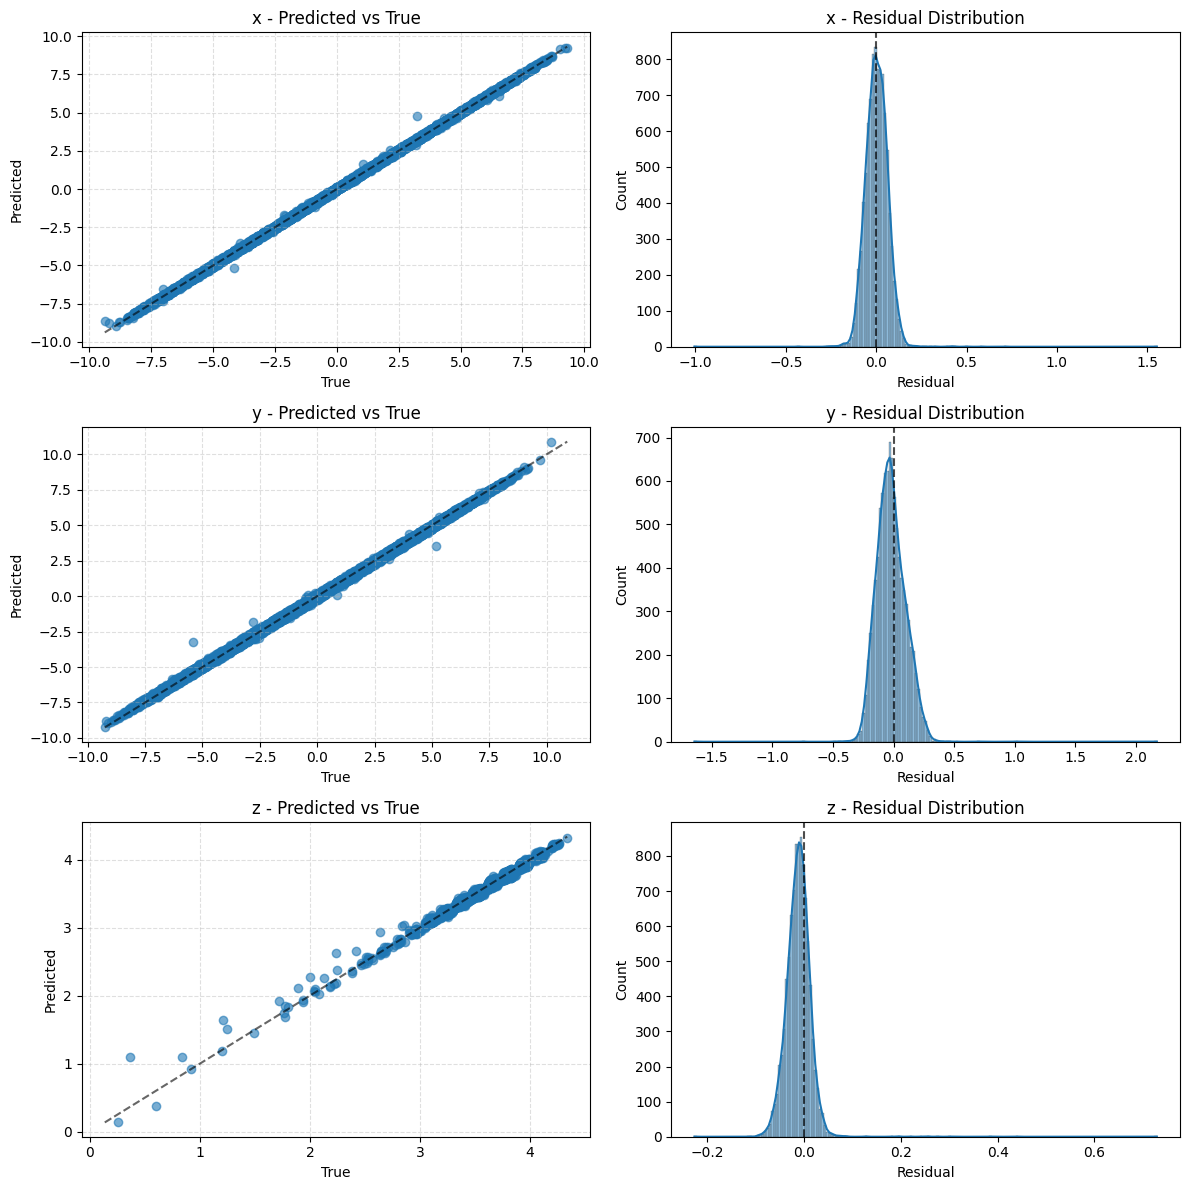

In [7]:
# Generate comprehensive regression diagnostics
print("\nGenerating regression diagnostic plots...")
plot_regression_diagnostics(
    predictions=predictions,
    targets=targets,
    component_names=["x", "y", "z"],
    show=True,
)


### Euclidean Error Histogram

A 1D histogram showing the distribution of euclidean errors (L2 norm of prediction - target).
This provides a clear view of how close predictions are to targets overall.

**How to interpret:**
- Lower errors indicate better model performance
- The histogram should ideally be left-skewed (most errors are small)
- Mean and median lines help identify typical error magnitudes
- Log scale can help visualize long tails in error distribution

**What to look for:**
- Most samples should have small errors (left side of histogram)
- Long tails indicate some samples are much harder to predict
- Compare mean vs median to detect skewness



Generating euclidean error histogram (linear scale)...


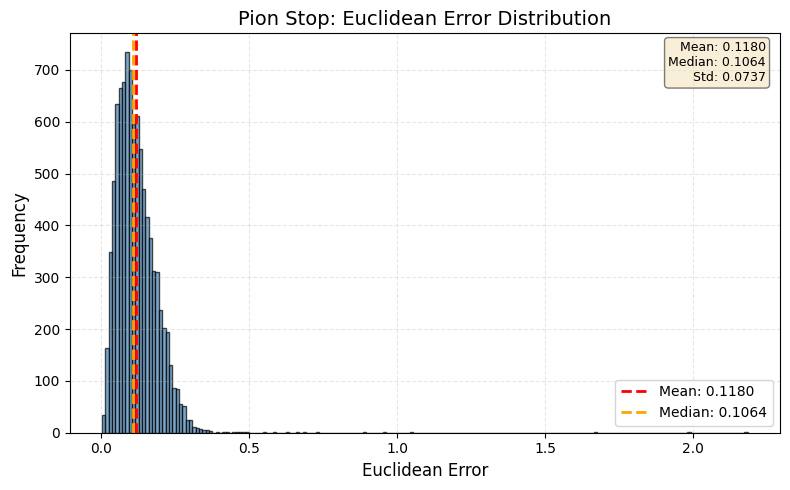

In [8]:
# Generate euclidean error histogram (linear scale)
print("\nGenerating euclidean error histogram (linear scale)...")
plot_euclidean_error_histogram(
    predictions=predictions,
    targets=targets,
    log_scale=False,
    title="Pion Stop: Euclidean Error Distribution",
    show=True,
)



Generating euclidean error histogram (log scale)...


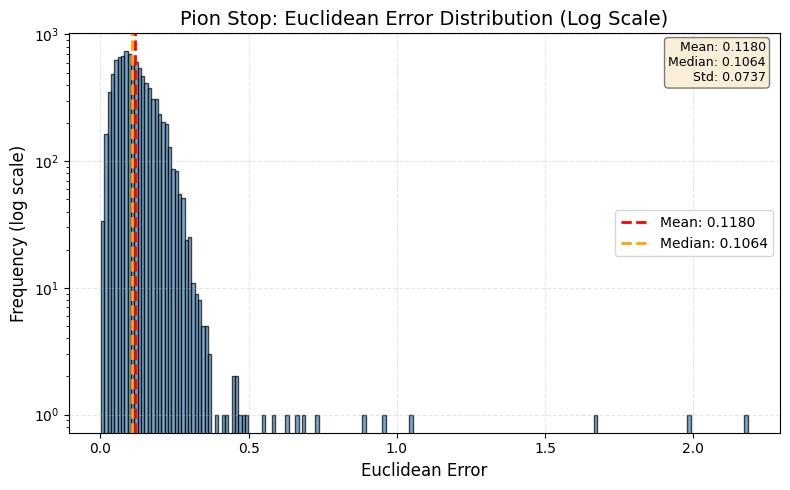

In [9]:
# Generate euclidean error histogram (log scale)
print("\nGenerating euclidean error histogram (log scale)...")
plot_euclidean_error_histogram(
    predictions=predictions,
    targets=targets,
    log_scale=True,
    title="Pion Stop: Euclidean Error Distribution (Log Scale)",
    show=True,
)


### Error Embedding Space Visualization

Visualize the model's embedding space colored by euclidean error magnitude using t-SNE/UMAP.
This helps detect overfitting patterns, such as clusters of high-error samples.

**How to interpret:**
- Points are colored by error magnitude (binned into quantiles)
- Clusters of high-error points indicate systematic failure modes
- If high errors are scattered randomly, the model may be underfitting
- If high errors form distinct clusters, the model may be overfitting to certain patterns

**What to look for:**
- **Good**: Low errors are distributed throughout the embedding space
- **Concerning**: Distinct clusters of high-error points (suggests overfitting to specific patterns)
- **Also concerning**: High errors scattered everywhere (suggests underfitting or data quality issues)



Generating error embedding space visualization (t-SNE)...
This may take a few minutes for large datasets...


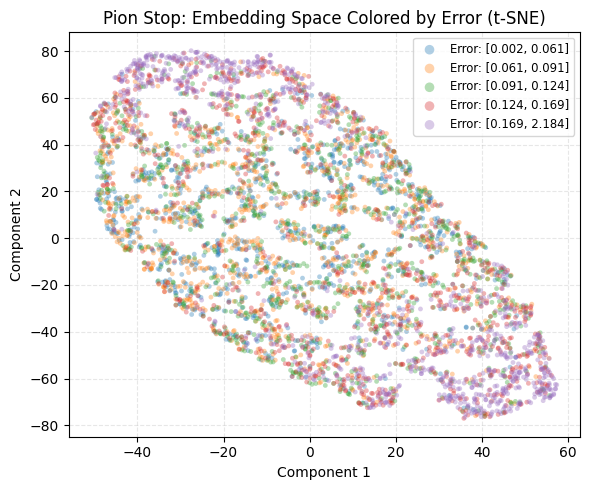

In [10]:
# Generate error embedding space visualization (t-SNE)
print("\nGenerating error embedding space visualization (t-SNE)...")
print("This may take a few minutes for large datasets...")
plot_error_embedding_space(
    embeddings=embeddings,
    predictions=predictions,
    targets=targets,
    method="tsne",
    perplexity=30.0,
    max_samples=5000,  # Limit samples for faster computation
    title="Pion Stop: Embedding Space Colored by Error (t-SNE)",
    show=True,
)


In [11]:
# Generate error embedding space visualization (UMAP - often faster than t-SNE)
'''
print("\nGenerating error embedding space visualization (UMAP)...")
plot_error_embedding_space(
    embeddings=embeddings,
    predictions=predictions,
    targets=targets,
    method="umap",
    max_samples=5000,  # Limit samples for faster computation
    title="Pion Stop: Embedding Space Colored by Error (UMAP)",
    show=True,
)
'''



Generating error embedding space visualization (UMAP)...
/home/jack/miniconda3/envs/pioneerml/lib/python3.11/site-packages/umap/umap_.py:2021: UserWarning: precomputed_knn[2] (knn_search_index) is not an NNDescent object: transforming new data with transform will be unavailable.
  warn(




KeyboardInterrupt

